In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import sys
import numpy.linalg as la
from tabulate import tabulate
import random

# 1a

In [2]:
def gram_schmidt(X):
    # X is an n-by-p matrix.
    # Returns U an orthonormal matrix.
    # eps is a threshold value to identify if a vector
    # is nearly a zero vector.
    eps = 1e-12

    n, p = X.shape
    U = np.zeros((n, 0))
    for j in range(p):
        # Get the j-th column of matrix X
        v = X[:, j]
        # Write your own code here: Perform the
        # orthogonalization by subtracting the projections on
        # all columns of U. And then check whether the vector
        # you get is nearly a zero vector.
        vbar = v - U @ U.T @ v
        norm = la.norm(vbar)
        if norm > eps:
            vbar = (1 / norm) * vbar
        U = np.hstack((U, np.reshape(vbar, (n, 1))))
    return U

In [3]:
def hilbert_matrix(n):
    X = np.array(
        [[1.0 / (i + j - 1) for i in range(1, n + 1)] for j in range(1, n + 1)]
    )
    return X


size_hilbert = 7
matrix_hilbert = hilbert_matrix(size_hilbert)

# 1b

In [4]:
def compute_hilbert_error(gs_hilbert, size_hilbert):
    ortho_hilbert = gs_hilbert.T @ gs_hilbert
    identity = np.eye(size_hilbert)
    return la.norm(ortho_hilbert - identity, ord=1)

This error computation checks orthogonality by computing $G.T \cdot G$, which should yield the identity matrix is we produced an orthonormal basis (i.e. all vectors are orthogonal to the other vectors unless that vector is itself, in which case the dot product should be $1$ since they are normalalized). We check this by evaluating the L1 norm from the identity matrix.

In [5]:
gs_hilbert_original = gram_schmidt(matrix_hilbert)
error_original = compute_hilbert_error(gs_hilbert_original, size_hilbert)
print(error_original)

0.24615611198508858


Using this method, we get an error of approximately 0.25.

# 1c

In [6]:
def modified_gram_schmidt(X):
    # Define a threshold value to identify if a vector
    # is nearly a zero vector.
    eps = 1e-12

    n, p = X.shape
    U = np.zeros((n, 0))

    for j in range(p):
        # Get the j-th column of matrix X
        v = X[:, j]
        for i in range(j):
            # Compute and subtract the projection of
            # vector v onto the i-th column of U
            v = v - np.dot(U[:, i], v) * U[:, i]
        v = np.reshape(v, (-1, 1))
        # Check whether the vector we get is nearly
        # a zero vector
        if np.linalg.norm(v) > eps:
            # Normalize vector v and append it to U
            U = np.hstack((U, v / np.linalg.norm(v)))

    return U

In [7]:
gs_hilbert_modified = modified_gram_schmidt(matrix_hilbert)
error_modified = compute_hilbert_error(gs_hilbert_modified, size_hilbert)
print(error_modified)

7.949993888719218e-09


Using this method, we get an error near 0, a significant improvement from the previous method. Between the original and modified G-S algorithm, the projection of vector onto a column of $U$ is computed differently. In the original, this is computed in a single step, whereas the modified does this separately for each column in $U$. The first approach leads to a error accumulation in calculating the new vector against existing ones together. These small error accumulations can lead to significant error differences when dealing with a large matrix. On the other hand, the modified method subtracts the projection component for the previous columns of $U$ individually, making it less susceptible to the accumulated errors.

# 6a

In [8]:
# d = sio.loadmat('face_emotion_data.mat')
d = np.load("face_emotion_data.npz")
X = d["X"]
y = d["y"]

n, p = np.shape(X)

# error rate for regularized least squares
error_RLS = np.zeros((8, 7))
# error rate for truncated SVD
error_SVD = np.zeros((8, 7))

# SVD parameters to test
k_vals = np.arange(9) + 1
param_err_SVD = np.zeros(len(k_vals))

# RLS parameters to test
lambda_vals = np.array([0, 0.5, 1, 2, 4, 8, 16])
param_err_RLS = np.zeros(len(lambda_vals))

In [9]:
def truncated_svd(
    features: np.ndarray, labels: np.ndarray, k_vals, subset_count: int = 8
) -> float:
    sample_count, feature_count = features.shape
    subset_size = sample_count // subset_count

    # Reshape arrays for easier subset-level manipulation
    features = features.reshape(subset_count, subset_size, feature_count)
    labels = labels.reshape(subset_count, subset_size)

    subset_idcs = np.arange(subset_count)
    train_set_size = (subset_count - 2) * subset_size
    subset_err_counts = np.zeros((subset_count, subset_count))

    for reg_index in range(subset_count):
        current_hold_out_index = 0

        for hold_out_index in range(subset_count):
            if reg_index != hold_out_index:
                current_features = np.zeros((0, feature_count))
                current_labels = np.zeros((0,))

                for subset_index in range(subset_count):
                    if subset_index != reg_index and subset_index != hold_out_index:
                        current_features = np.concatenate(
                            (current_features, features[subset_index])
                        )
                        current_labels = np.concatenate(
                            (current_labels, labels[subset_index])
                        )

                U, S, Vh = la.svd(current_features, full_matrices=True)

                reg_weights = []
                reg_error_counts = []

                for index in range(len(k_vals)):
                    num_params = k_vals[index]
                    new_U = U[:, :num_params]
                    new_S = np.diag(1 / S[:num_params])
                    new_Vh = Vh[:num_params, :]

                    pseudo_inv_X = new_Vh.T @ new_S.T @ new_U.T
                    current_weights = pseudo_inv_X @ current_labels

                    reg_predictions = features[reg_index] @ current_weights
                    reg_error_counts.append(
                        sum(np.sign(reg_predictions) != np.sign(labels[reg_index]))
                    )
                    param_err_SVD[index] += reg_error_counts[-1]
                    reg_weights.append(current_weights)

                best_param_index, best_error = None, float("inf")
                for i in range(feature_count):
                    if reg_error_counts[i] < best_error:
                        best_param_index, best_error = i, reg_error_counts[i]

                hold_out_predictions = (
                    features[hold_out_index] @ reg_weights[best_param_index]
                )
                subset_err_counts[reg_index][hold_out_index] = (
                    sum(
                        np.sign(hold_out_predictions) != np.sign(labels[hold_out_index])
                    )
                    / subset_size
                )

                error_SVD[reg_index][current_hold_out_index] = subset_err_counts[
                    reg_index
                ][hold_out_index]
                current_hold_out_index += 1

    # Average over the entire dataset to find the classification error
    cls_err = np.sum(subset_err_counts) / (subset_count * (subset_count - 1))
    return cls_err

In [10]:
# Run on the dataset with all features included
full_feat_svd_err = truncated_svd(X, y, np.arange(9) + 1)

In [11]:
param_err_SVD = param_err_SVD / (8 * 7)

print(full_feat_svd_err)
print(f"Error estimate: {full_feat_svd_err*100:.3f}%")

0.11160714285714286
Error estimate: 11.161%


# 6b

From class, we showed that the $\hat w_\lambda = (X^T X + \lambda I)^{-1} X^T y$.

Note the following: $X = U \Sigma V^T$, $X^T = V \Sigma^T U^T$, $U^T U = U U^T = I$, $V^T V = V V^T = I$

Given these facts, $\hat w_\lambda = (V \Sigma^T U^T U \Sigma V^T + \lambda V V^T)^{-1} V \Sigma^T U^T y$. Then, $\hat w_\lambda = (V (\Sigma^T \Sigma + \lambda) V^T)^{-1} V \Sigma^T U^T y$. We know that $\Sigma$ is $nxd$ and $\Sigma^T$ is $dxn$, and since $\Sigma$ is a diagonal matrix, we know that $\Sigma^T \Sigma$ is $dxd$ and a diagonal matrix where the diagonal entries are ${s_i}^2$. Then, we add $\lambda$ to each diagonal entry of $\Sigma^T \Sigma$ since $\lambda$ was multiplied with $I$. Let $A$ denote the diagonal matrix where the diagonal entries are ${s_i}^2 + \lambda$. Furthermore, let $B$ be the diagonal matrix where the diagonal entries $\frac{1}{{s_i}^2 + \lambda}$. Then, we can simplify and get $\hat w_\lambda = V B V^T V \Sigma^T U^T y = V B \Sigma^T U^T y$. Again, multiplying $B$ by $\Sigma^T$ gives us a $dxn$ matrix where the diagonal entries are $\frac{{s_i}^2}{{s_i}^2 + \lambda}$, and all other entries are $0$, and denote this new matrix $C$. Thus, we get that $\hat w_\lambda = V C U^T y$. Furthermore, $y$ and $\lambda$ (per parameter iteration) are given, as well as SVD outputs $U$, $\Sigma$, and $V^T$, which we can use to calculate $U^T$, $C$, and $V$.

In [12]:
def regularized_ls(
    features: np.ndarray, labels: np.ndarray, subset_count: int = 8
) -> float:
    sample_count, feature_count = features.shape
    subset_size = sample_count // subset_count

    # Reshape arrays for easier subset-level manipulation
    features = features.reshape(subset_count, subset_size, feature_count)
    labels = labels.reshape(subset_count, subset_size)

    subset_idcs = np.arange(subset_count)
    train_set_size = (subset_count - 2) * subset_size
    subset_err_counts = np.zeros((subset_count, subset_count))

    for reg_index in range(subset_count):
        current_hold_out_index = 0

        for hold_out_index in range(subset_count):
            if reg_index != hold_out_index:
                current_features = np.zeros((0, feature_count))
                current_labels = np.zeros((0,))

                for subset_index in range(subset_count):
                    if subset_index != reg_index and subset_index != hold_out_index:
                        current_features = np.concatenate(
                            (current_features, features[subset_index])
                        )
                        current_labels = np.concatenate(
                            (current_labels, labels[subset_index])
                        )

                U, S, Vh = la.svd(current_features, full_matrices=True)

                reg_weights = []
                reg_error_counts = []

                for index in range(len(lambda_vals)):
                    lambda_val = lambda_vals[index]
                    new_S = np.zeros((feature_count, train_set_size))
                    for sigma_index in range(feature_count):
                        new_S[sigma_index, sigma_index] = S[sigma_index] / (
                            S[sigma_index] ** 2 + lambda_val
                        )

                    rls_X = Vh.T @ new_S @ U.T
                    current_weights = rls_X @ current_labels

                    reg_predictions = features[reg_index] @ current_weights
                    reg_error_counts.append(
                        sum(np.sign(reg_predictions) != np.sign(labels[reg_index]))
                    )
                    param_err_RLS[index] += reg_error_counts[-1]
                    reg_weights.append(current_weights)

                best_param_index, best_error = None, float("inf")
                for i in range(len(lambda_vals)):
                    if reg_error_counts[i] < best_error:
                        best_param_index, best_error = i, reg_error_counts[i]

                hold_out_predictions = (
                    features[hold_out_index] @ reg_weights[best_param_index]
                )
                subset_err_counts[reg_index][hold_out_index] = (
                    sum(
                        np.sign(hold_out_predictions) != np.sign(labels[hold_out_index])
                    )
                    / subset_size
                )

                error_RLS[reg_index][current_hold_out_index] = subset_err_counts[
                    reg_index
                ][hold_out_index]
                current_hold_out_index += 1

    # Average over the entire dataset to find the classification error
    cls_err = np.sum(subset_err_counts) / (subset_count * (subset_count - 1))
    return cls_err

In [13]:
# Run on the dataset with all features included
full_feat_rls_err = regularized_ls(X, y)

In [14]:
param_err_RLS = param_err_RLS / (8 * 7)

print(full_feat_rls_err)
print(f"Error estimate: {full_feat_rls_err*100:.3f}%")

0.04799107142857143
Error estimate: 4.799%


# 6c

In [15]:
feature_idcs = [i for i in range(p)]
num_trials = 1000

# SVD parameters to test
k_vals = np.arange(12) + 1
param_err_SVD = np.zeros(len(k_vals))

# RLS parameters to test
lambda_vals = np.array([0, 0.5, 1, 2, 4, 8, 16])
param_err_RLS = np.zeros(len(lambda_vals))

all_svd_errors = [0 for i in range(num_trials)]
all_rls_errors = [0 for i in range(num_trials)]

for trial in range(num_trials):
    param_err_SVD = np.zeros(len(k_vals))
    param_err_RLS = np.zeros(len(lambda_vals))
    new_X = np.hstack((X, X @ np.random.rand(9, 3)))
    all_svd_errors[trial] = truncated_svd(new_X, y, np.arange(p + 3) + 1)
    all_rls_errors[trial] = regularized_ls(new_X, y)

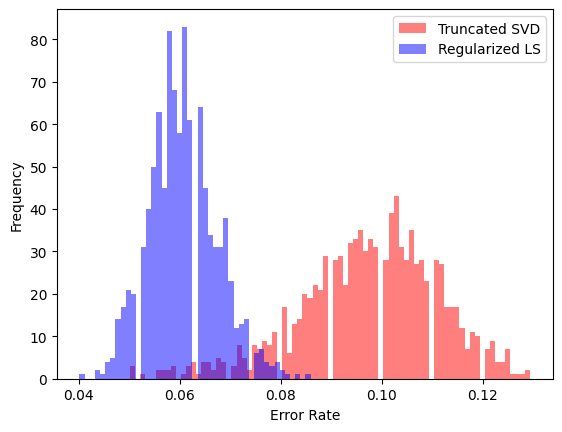

In [16]:
bin_size = 0.001
svd_bin_count = int((max(all_svd_errors) - min(all_svd_errors)) // bin_size)
rls_bin_count = int((max(all_rls_errors) - min(all_rls_errors)) // bin_size)

plt.hist(
    all_svd_errors, bins=svd_bin_count, alpha=0.5, label="Truncated SVD", color="red"
)
plt.hist(
    all_rls_errors, bins=rls_bin_count, alpha=0.5, label="Regularized LS", color="blue"
)
plt.xlabel("Error Rate")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [17]:
svd_mean, svd_std = np.mean(all_svd_errors), np.std(all_svd_errors)
rls_mean, rls_std = np.mean(all_rls_errors), np.std(all_rls_errors)
print(f"SVD error mean = {svd_mean:.4f}, standard deviation = {svd_std:.4f}")
print(f"RLS error mean = {rls_mean:.4f}, standard deviation = {rls_std:.4f}")

SVD error mean = 0.0975, standard deviation = 0.0138
RLS error mean = 0.0607, standard deviation = 0.0067


No, these features will not be useful since they are a linear combination of existing features. Therefore, they will not add any meaningful information. In particular, since the new features are redundant, they are in $span(X)$. As above, we see that RLS outperforms SVD like in the part (a). The error rates are also roughly similar to the error rates seen in part (a), indicating no substantial improvement by adding these new features. Since the new features generated are random linear combinations, the weights we get are slightly different each trial and induces variability in the error rates. Furthermore, we see that RLS seems to have less variability. Overall, less variability and lower error rate indicate RLS appears to be a better solution for this problem.